In [1]:
import pandas as pd

In [2]:
import os

In [3]:
import matplotlib.pyplot as plt

In [4]:
entropy_files_path = 'output/gpt2/'
files = os.listdir(entropy_files_path)

In [5]:
entropies = [file for file in files if 'entropies.csv' in file]
stats = [file for file in files if 'stats.csv' in file]

In [6]:
entropies_dfs = [pd.read_csv(entropy_files_path + file) for file in entropies]
stats_dfs = [pd.read_csv(entropy_files_path + file) for file in stats]

In [7]:
assert len(entropies_dfs) == len(stats_dfs)
for i in range(len(entropies_dfs)):
    entropies_dfs[i]['file'] = entropies[i].split('_')[0]
    stats_dfs[i]['file'] = stats[i].split('_')[0]

In [8]:
entropies_df = pd.concat(entropies_dfs)
stats_df = pd.concat(stats_dfs)

# Analysis at different levels

We can run the analysis at the bible, testament, book, and chapter levels, and for each report two histograms: one for H_s, and one for H_r. At the book and chapter levels we will use only H_r.

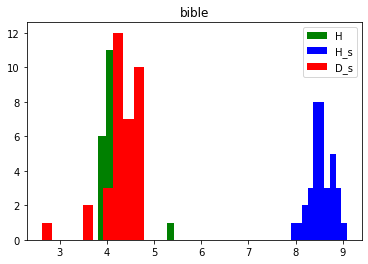

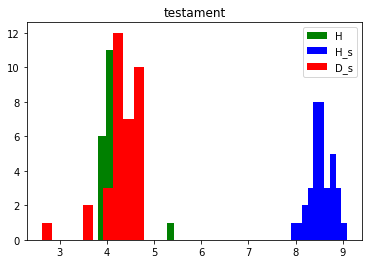

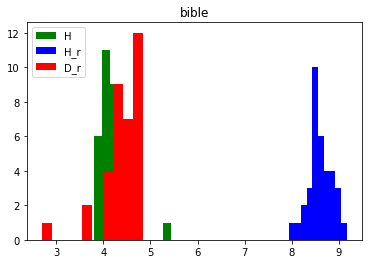

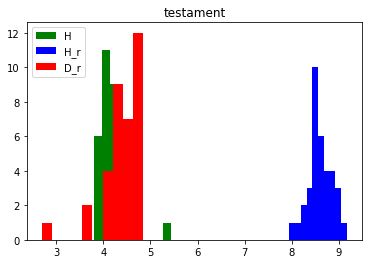

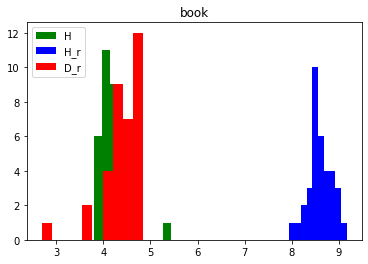

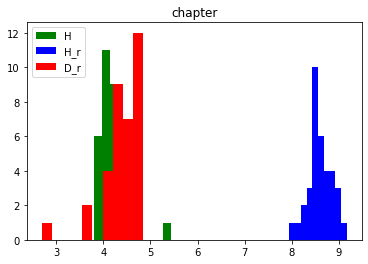

In [9]:
colors = {'H': 'green', 'H_r': 'blue', 'H_s': 'blue', 'D_r': 'red', 'D_s': 'red'}
levels = {'s': ('bible', 'testament'), 'r': ('bible', 'testament', 'book', 'chapter')}

for method in ('s', 'r'):
    for level in levels[method]:
        for col in ('H', f'H_{method}', f'D_{method}'):
            plt.hist(entropies_df[entropies_df['level'] == 'bible'][col], color=colors[col], label=col)
        plt.title(level)
        plt.legend()
        plt.show()

Now let's look at some statistics

In [10]:
# Average over all texts at each level
col_aggs = {col: ['mean', 'std'] for col in entropies_df.columns if col not in {'level', 'file'}}
# Add one more column that is the number of texts for that level
col_aggs[list(col_aggs.keys())[0]].append('count')
stats = entropies_df.groupby('level').agg(col_aggs)

# No _s in book and chapter levels
for col in stats.columns:
    if '_s' in col[0]:
        stats.at['book', col] = 'N/A'
        stats.at['chapter', col] = 'N/A'
        
# Drop verses
stats.drop(['verse'], inplace=True)

# Sort by hierarchy
hierarchy = ['bible', 'testament', 'book', 'chapter']
stats['hierarchy'] = stats.index.map(lambda x: hierarchy.index(x))
stats.sort_values(by='hierarchy', inplace=True)
stats.drop(columns=['hierarchy'], inplace=True)

In [11]:
stats

n_tokens                               H                 H_s  \
                    mean            std  count      mean       std      mean   
level                                                                          
bible      370744.400000  293438.707838     35  4.210938  0.296422  8.529697   
testament  288357.422222  186459.787490     45  4.264321  0.307863  8.516347   
book        10408.732959   11813.517449   1247  4.519883  0.524976       N/A   
chapter       780.981234     377.717856  16679  4.528456  0.597955       N/A   

                          H_r                 D_r                 D_s  \
                std      mean       std      mean       std      mean   
level                                                                   
bible      0.254352  8.596414  0.256691  4.385476  0.406714  4.318759   
testament   0.23013  8.658883  0.278166  4.394562  0.380355  4.252026   
book            N/A  8.717107  0.351266  4.197224  0.494549       N/A   
chapter         N/A  8.753222  0.398076  4.224766  0.544349       N/A   

                     
                std  
level                
bible      0.407146  
testament  0.395525  
book            N/A  
chapter         N/A

It's surprising that the number of tokens varies so wildly across bibles. We can look at this in further detail.

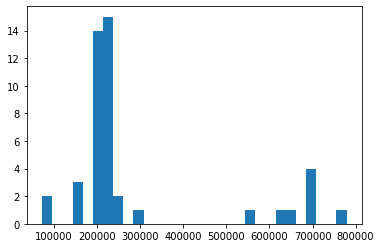

In [12]:
plt.hist(entropies_df[entropies_df['level'] == 'testament']['n_tokens'], bins=30)
plt.show()

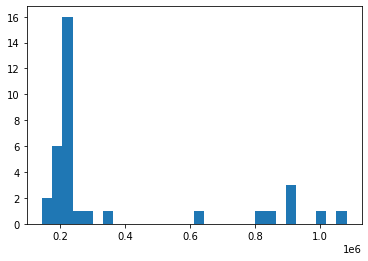

In [13]:
plt.hist(entropies_df[entropies_df['level'] == 'bible']['n_tokens'], bins=30)
plt.show()

So most of this variation seems to be due to the old vs new testament.

# Outlier analysis

What are the bibles with the lowest entropy differences?

In [14]:
entropies_df[(entropies_df['level'] == 'bible') & (entropies_df['D_r'] < 3)]

,level,n_tokens,H,H_s,H_r,D_r,D_s,file
0,bible,219289,5.430104,8.060063,8.133739,2.703635,2.629959,eng-x-bible-diaglot


Is this a particularly short or long bible? Judging from the distribution shown above, it is rather short, but not the shortest. This "diaglot" bible is a literal word-by-word translation of the Greek bible. The text is order in an odd manner and it's quite difficult to read as English. This probably means that the entropy is higher than usual (and this is consistent with the observation), which causes the small entropy difference.

In [15]:
entropies_df[(entropies_df['level'] == 'bible') & (entropies_df['D_r'] < 4)]

,level,n_tokens,H,H_s,H_r,D_r,D_s,file
0,bible,215426,4.614476,8.203814,8.278585,3.664109,3.589337,eng-x-bible-etheridge
0,bible,219289,5.430104,8.060063,8.133739,2.703635,2.629959,eng-x-bible-diaglot
0,bible,227721,4.236122,7.911118,7.948277,3.712155,3.674996,eng-x-bible-basic


Basic does not have a high entropy rate, but a small unigram entropy. This is probably due to the more limited vocabulary. I can't understand very much what the case is for the Etheridge bible. The "basic" bible is still in English, so it should be kept, but the "diaglot" bible is arguably not in English. If we remove it, how does the analysis change?

In [16]:
# Average over all texts at each level
col_aggs = {col: ['mean', 'std'] for col in entropies_df.columns if col not in {'level', 'file'}}
# Add one more column that is the number of texts for that level
col_aggs[list(col_aggs.keys())[0]].append('count')
stats = entropies_df[entropies_df['file'] != 'eng-x-bible-diaglot'].groupby('level').agg(col_aggs)

# No _s in book and chapter levels
for col in stats.columns:
    if '_s' in col[0]:
        stats.at['book', col] = 'N/A'
        stats.at['chapter', col] = 'N/A'
        
# Drop verses
stats.drop(['verse'], inplace=True)

# Sort by hierarchy
hierarchy = ['bible', 'testament', 'book', 'chapter']
stats['hierarchy'] = stats.index.map(lambda x: hierarchy.index(x))
stats.sort_values(by='hierarchy', inplace=True)
stats.drop(columns=['hierarchy'], inplace=True)

In [17]:
stats

n_tokens                               H                 H_s  \
                    mean            std  count      mean       std      mean   
level                                                                          
bible      375198.970588  296647.937022     34  4.175080  0.210149   8.54351   
testament  289927.159091  188314.447397     44  4.237826  0.254282  8.526717   
book        10459.281148   11854.270477   1220  4.492495  0.490475       N/A   
chapter       779.945185     377.921659  16419  4.510330  0.580869       N/A   

                         H_r                 D_r                 D_s            
               std      mean       std      mean       std      mean       std  
level                                                                           
bible      0.24449  8.610022  0.247405  4.434942  0.286693   4.36843  0.286048  
testament   0.2219  8.670818  0.269475  4.432992  0.282894  4.288891  0.312248  
book           N/A  8.727856  0.344727  4.235361  0.424588       N/A       N/A  
chapter        N/A  8.761994  0.393450  4.251664  0.502009       N/A       N/A

Now the statistical uncertainties become closer to the values calculated on a single bible. Not that, while we calculated the cross-entropy between GPT-2 and the bible, the cross-entropy is expected to be higher than or equal to the entropy (Gibbs' Inequality). Thus, the entropy difference should be even **larger** than reported here, unlike presented in Montemurro & Zanette.